In [1]:
# coding: utf-8
import os
import datetime

import pandas as pd
import numpy as np
import scipy
import lightgbm as lgb
import xgboost as xgb
from sklearn import metrics
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns

from mydatools.features_analyze import get_top_k_corr
from mydatools.plot import plot_grid_search_result

from common import read_features, save_features

% matplotlib inline

## Config

In [2]:
# trn_path = './data/input/train.csv'
# tst_path = './data/input/test.csv'
id_col = 'id'
label_col = 'visitors'

submission_path = './data/output/submission/lightgbm.csv'
output_id_col = id_col
output_label_col = label_col

## Load Data

In [3]:
full_df, feature_columns = read_features()

In [4]:
# dataset type
is_trn = full_df['ds_type'] == 'trn'
is_tst = full_df['ds_type'] == 'tst'

In [5]:
full_df.head()

,air_store_id,ds_type,id,visit_date,visitors,visitors_o,air_genre_name,air_area_name,latitude,longitude,...,air_genre_name-visit_dayofweek-visitors_min,air_genre_name-visit_dayofweek-visitors_q25,air_genre_name-visit_dayofweek-visitors_q50,air_genre_name-visit_dayofweek-visitors_q75,air_area_name-visit_dayofweek-visitors_avg,air_area_name-visit_dayofweek-visitors_max,air_area_name-visit_dayofweek-visitors_min,air_area_name-visit_dayofweek-visitors_q25,air_area_name-visit_dayofweek-visitors_q50,air_area_name-visit_dayofweek-visitors_q75
0,air_ba937bf13d40fb24,trn,air_ba937bf13d40fb24_2016-01-13,2016-01-13,3.258097,25,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,...,0.693147,1.945910,2.639057,3.218876,2.777286,4.976734,0.693147,2.197225,2.890372,3.401197
1,air_ba937bf13d40fb24,trn,air_ba937bf13d40fb24_2016-01-14,2016-01-14,3.496508,32,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,...,0.693147,2.079442,2.639057,3.218876,2.754310,4.700480,0.693147,2.197225,2.833213,3.367296
2,air_ba937bf13d40fb24,trn,air_ba937bf13d40fb24_2016-01-15,2016-01-15,3.401197,29,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,...,0.693147,2.302585,2.944439,3.465736,2.925904,4.812184,0.693147,2.397895,3.044522,3.555348
3,air_ba937bf13d40fb24,trn,air_ba937bf13d40fb24_2016-01-16,2016-01-16,3.135494,22,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,...,0.693147,2.484907,3.091042,3.583519,2.730508,4.867534,0.693147,2.079442,2.772589,3.367296
4,air_ba937bf13d40fb24,trn,air_ba937bf13d40fb24_2016-01-18,2016-01-18,1.945910,6,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,...,0.693147,1.791759,2.484907,3.044522,2.450613,5.723585,0.693147,1.791759,2.484907,3.091042


In [6]:
feature_columns

['air_genre_name_Asian',
 'air_genre_name_Bar/Cocktail',
 'air_genre_name_Cafe/Sweets',
 'air_genre_name_Creative cuisine',
 'air_genre_name_Dining bar',
 'air_genre_name_International cuisine',
 'air_genre_name_Italian/French',
 'air_genre_name_Izakaya',
 'air_genre_name_Japanese food',
 'air_genre_name_Karaoke/Party',
 'air_genre_name_Okonomiyaki/Monja/Teppanyaki',
 'air_genre_name_Other',
 'air_genre_name_Western food',
 'air_genre_name_Yakiniku/Korean food',
 'latitude',
 'longitude',
 'holiday_flg',
 'visit_month',
 'visit_dayofweek',
 'visit_days_in_month',
 'date_index',
 'reserve_count',
 'total_reserve_visitors',
 'ahead_reserve_hours_median',
 'reserve_in_1day_count',
 'reserve_in_2day_count',
 'reserve_in_3day_count',
 'reserve_in_7day_count',
 'reserve_in_30day_count',
 'reserve_in_1day_visitors',
 'reserve_in_2day_visitors',
 'reserve_in_3day_visitors',
 'reserve_in_7day_visitors',
 'reserve_in_30day_visitors',
 'air_store_id-visitors_avg',
 'air_store_id-visitors_max',
 '

In [7]:
the_store_df = full_df[full_df['air_store_id'] == 'air_ba937bf13d40fb24'].copy()

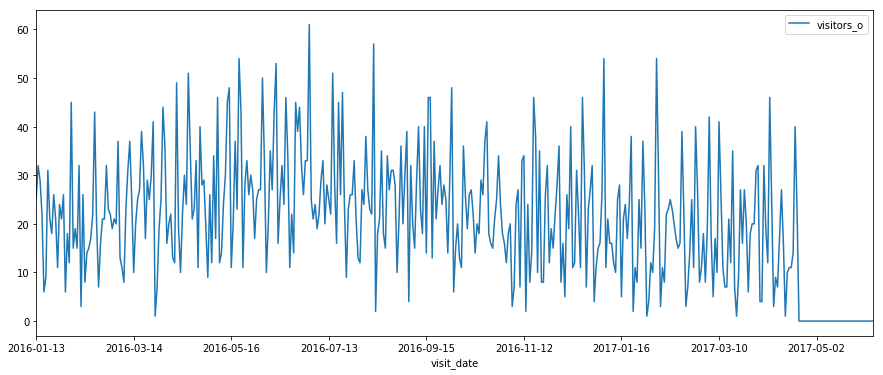

In [8]:
the_store_df.plot(x='visit_date', y='visitors_o', figsize=(15,6))

## Preprocessing

In [9]:
trn_df = full_df[is_trn]
tst_df = full_df[is_tst]

X = trn_df[feature_columns]
y = trn_df[label_col]
X_trn, X_val, y_trn, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

X_tst = tst_df[feature_columns]

## LightGBM

In [10]:
trn_lgb = lgb.Dataset(X_trn.values, y_trn)
val_lgb = lgb.Dataset(X_val.values, y_val, reference=trn_lgb)

In [11]:
pred_df = pd.DataFrame()

In [12]:
model_num = 10
for i in range(model_num):
    print('-'*80)
    print('the no.%d model.'%i)
    params = {
        'boosting': 'gbdt',
        'application': 'mse',
        'metric': 'rmse',
        'learning_rate': 0.07,
        'max_depth': 5,
        'num_leaves': 20,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.5,
        'bagging_freq': 1,
        'seed': i*i,
        'reg_alpha': 0.1,
    }
    lgbm = lgb.train(params, trn_lgb, 1000, valid_sets=[trn_lgb, val_lgb], 
                     early_stopping_rounds=20, verbose_eval=100)
    pred_df['lgbm%d'%i] = lgbm.predict(X_tst)

--------------------------------------------------------------------------------
the no.0 model.
Training until validation scores don't improve for 20 rounds.
[100]	training's rmse: 0.49785	valid_1's rmse: 0.499459
[200]	training's rmse: 0.49252	valid_1's rmse: 0.496129
[300]	training's rmse: 0.488782	valid_1's rmse: 0.49406
[400]	training's rmse: 0.485702	valid_1's rmse: 0.492614
[500]	training's rmse: 0.482882	valid_1's rmse: 0.491545
[600]	training's rmse: 0.480555	valid_1's rmse: 0.490666
[700]	training's rmse: 0.478354	valid_1's rmse: 0.490049
[800]	training's rmse: 0.47636	valid_1's rmse: 0.48942
[900]	training's rmse: 0.47465	valid_1's rmse: 0.489108
[1000]	training's rmse: 0.47301	valid_1's rmse: 0.488678
--------------------------------------------------------------------------------
the no.1 model.
Training until validation scores don't improve for 20 rounds.
[100]	training's rmse: 0.498526	valid_1's rmse: 0.500386
[200]	training's rmse: 0.49254	valid_1's rmse: 0.496449
[300]

In [13]:
pred_df

,lgbm0,lgbm1,lgbm2,lgbm3,lgbm4,lgbm5,lgbm6,lgbm7,lgbm8,lgbm9
0,0.885932,0.926781,1.068038,1.027113,0.983539,0.899510,0.890224,1.006508,0.875549,0.936849
1,2.915089,2.965652,2.921326,3.000044,3.037770,2.964792,2.930961,3.002754,2.977091,2.970561
2,3.107996,3.169654,3.069324,3.077753,3.204200,3.074887,3.109939,3.121525,3.117745,3.101936
3,3.377869,3.423370,3.330633,3.371560,3.386358,3.338517,3.368061,3.349475,3.370281,3.393139
4,3.466407,3.525725,3.448248,3.487007,3.502055,3.434327,3.478062,3.444716,3.455756,3.475984
5,3.660485,3.730642,3.648022,3.657515,3.671751,3.642778,3.678302,3.631662,3.643536,3.684537
6,2.641949,2.762997,2.858706,2.593816,2.618360,2.636336,2.671738,2.624032,2.683445,2.724512
7,0.885932,0.926781,1.068038,1.027113,0.983539,0.899510,0.890224,1.006508,0.875549,0.936849
8,2.931643,3.007351,2.973264,3.020963,3.007754,3.002924,2.895734,3.044846,3.016130,3.023478
9,3.131752,3.198802,3.126382,3.092778,3.168738,3.125069,3.059581,3.154305,3.163271,3.153637


In [14]:
# imp_df = pd.DataFrame([lgbm.feature_importance()], 
#                       columns=feature_columns, 
#                       index=['importance']).T.sort_values(by='importance', ascending=False)
# imp_df

## predict

In [15]:
pred_df['mean'] = pred_df.mean(axis=1)
pred_res = pred_df['mean'].apply(np.expm1)

In [16]:
res_df = pd.DataFrame({
    output_id_col: tst_df[output_id_col].values,
    output_label_col: pred_res,
})
res_df[[output_id_col, output_label_col]].to_csv(submission_path, index=False)

In [17]:
pred_df

,lgbm0,lgbm1,lgbm2,lgbm3,lgbm4,lgbm5,lgbm6,lgbm7,lgbm8,lgbm9,mean
0,0.885932,0.926781,1.068038,1.027113,0.983539,0.899510,0.890224,1.006508,0.875549,0.936849,0.950004
1,2.915089,2.965652,2.921326,3.000044,3.037770,2.964792,2.930961,3.002754,2.977091,2.970561,2.968604
2,3.107996,3.169654,3.069324,3.077753,3.204200,3.074887,3.109939,3.121525,3.117745,3.101936,3.115496
3,3.377869,3.423370,3.330633,3.371560,3.386358,3.338517,3.368061,3.349475,3.370281,3.393139,3.370926
4,3.466407,3.525725,3.448248,3.487007,3.502055,3.434327,3.478062,3.444716,3.455756,3.475984,3.471829
5,3.660485,3.730642,3.648022,3.657515,3.671751,3.642778,3.678302,3.631662,3.643536,3.684537,3.664923
6,2.641949,2.762997,2.858706,2.593816,2.618360,2.636336,2.671738,2.624032,2.683445,2.724512,2.681589
7,0.885932,0.926781,1.068038,1.027113,0.983539,0.899510,0.890224,1.006508,0.875549,0.936849,0.950004
8,2.931643,3.007351,2.973264,3.020963,3.007754,3.002924,2.895734,3.044846,3.016130,3.023478,2.992409
9,3.131752,3.198802,3.126382,3.092778,3.168738,3.125069,3.059581,3.154305,3.163271,3.153637,3.137431
